In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import os
from IPython.display import display 

# Notebook Settings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 5]

# Input Files
studentInfo = "studentInfo.csv"

/home/mschots/trybe/trybe/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Funcoes Auxiliares TODO: ao fim do projeto agrupa-las num modulo. 
def plot_mean_bar(dataframe,x_col_list,y_col):
    if len(x_col_list) > 1:
        ax = (dataframe
             .groupby(x_col_list)[y_col]
             .mean()
             .unstack()
             .plot(kind = 'barh'))
        _= ax.legend(loc = "best",bbox_to_anchor=(1, 1))
    else:
        ax = (dataframe
             .groupby(x_col_list)[y_col]
             .mean()
             .plot(kind = 'barh'))
    return ax

def categorical_cardinality(dataframe):
    df = dataframe.copy()
    return {col:df[col].nunique() for col in df if df[col].dtype == 'object'}

def categorical_mean(dataframe,categorical):
    """Calcula a razao entre a media global do target e a media para cada valor possivel 
    da variavel categorica.
     ---------------------------------------------------------------------------
       Input: Dataframe,lista das variaveis categoricas
     ---------------------------------------------------------------------------
       Output: Um objeto Ipython Display contendo dataframes
    """
    
    df = dataframe.copy()
    global_mean = df.reproved.mean()
    for col in categorical:
        df_group = df.groupby(col).reproved.agg(['mean'])
        df_group['rate'] = df_group['mean'] / global_mean
        df_group.sort_values("rate",inplace = True,ascending = False)
        display(df_group)
        
def numerical_mean(dataframe,numerical,n_quantiles):
    """Calcula a razao entre a media global do target e a media para cada quartil
    da variavel numerica.
     ---------------------------------------------------------------------------
       Input: Dataframe,lista das variaveis numericas
     ---------------------------------------------------------------------------
       Output: Um objeto Ipython Display contendo dataframes"""
    
    df = dataframe.copy()
    global_mean = df.reproved.mean()
    for col in numerical:
        df_group = df.groupby(pd.Series(pd.qcut(df[col],q = n_quantiles))).reproved.agg(['mean'])
        df_group['rate'] = df_group['mean'] / global_mean
        df_group.sort_values("rate",inplace = True,ascending = False)
        display(df_group)

**Disclaimer**: O texto em português contem diversas omissões de acentuação devido a este notebook estar sendo escrito em um teclado nórdico. Deste modo, escrever å torna-se mais fácil do que escrever ç. Perdoem-me :)

# 1. Primeiro Experimento

## 1.1 Exploração do  *Info Dataset*

Começaremos explorando o dataset studentInfo pois o temos como a espinha dorsal do primeiro modelo que construiremos para resolver a questão de negócios que nos propusemos a resolver: **Quais estudantes falharão no Exame Final?**


Responder a essa pergunta com antecedência pode ajudar alguns estudantes a desvia-los do desfecho negativo.

In [3]:
info = pd.read_csv(Path("..",studentInfo),low_memory=False) # arquivo encontra-se uma pasta acima ../

In [4]:
f'Info Dataset Contem {info.shape[0]} linhas e {info.shape[1]} colunas'

'Info Dataset Contem 32593 linhas e 12 colunas'

In [5]:
info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [6]:
# Maybe some outliers?
info.describe()

,id_student,num_of_prev_attempts,studied_credits
count,3.259300e+04,32593.000000,32593.000000
mean,7.066877e+05,0.163225,79.758691
std,5.491673e+05,0.479758,41.071900
min,3.733000e+03,0.000000,30.000000
25%,5.085730e+05,0.000000,60.000000
50%,5.903100e+05,0.000000,60.000000
75%,6.444530e+05,0.000000,120.000000
max,2.716795e+06,6.000000,655.000000


Maioria dos Estudantes assistindo aos modulos pela primeira vez, como esperado. Ha um valor máximo de 6 tentativas anteriores que chama a atenção. Vamos investigar.

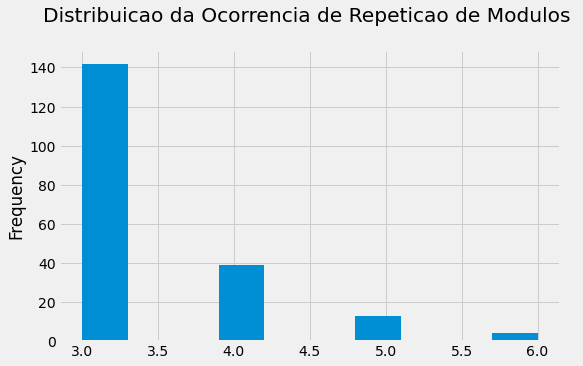

In [7]:
ax = info.query("num_of_prev_attempts >=3")['num_of_prev_attempts'].plot(kind = 'hist')
_= ax.set_title("Distribuicao da Ocorrencia de Repeticao de Modulos \n")

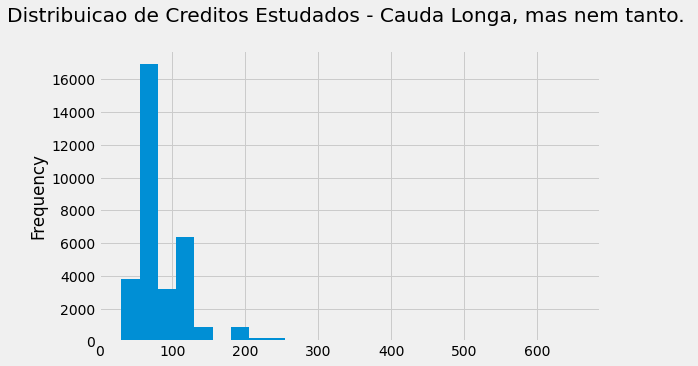

In [8]:
ax = info['studied_credits'].plot(kind = 'hist',bins=25)
_= ax.set_title("Distribuicao de Creditos Estudados - Cauda Longa, mas nem tanto. \n")

In [9]:
info.dtypes

code_module             object
code_presentation       object
id_student               int64
gender                  object
region                  object
highest_education       object
imd_band                object
age_band                object
num_of_prev_attempts     int64
studied_credits          int64
disability              object
final_result            object
dtype: object

In [10]:
info['id_student'].nunique() == info.shape[0]

False

In [11]:
duplicated_mask = info['id_student'].duplicated(keep = False)
info_duplicated = info[duplicated_mask]
info_duplicated.sort_values('id_student').head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
14395,DDD,2013J,8462,M,London Region,HE Qualification,30-40%,55<=,0,90,N,Withdrawn
17560,DDD,2014J,8462,M,London Region,HE Qualification,30-40%,55<=,1,60,N,Withdrawn
13091,DDD,2013B,24213,F,East Anglian Region,A Level or Equivalent,40-50%,0-35,0,90,N,Withdrawn
16332,DDD,2014B,24213,F,East Anglian Region,A Level or Equivalent,40-50%,0-35,1,60,N,Pass
2517,BBB,2013J,25629,F,Scotland,Lower Than A Level,20-30%,0-35,0,120,N,Withdrawn


In [12]:
f'{info_duplicated.query("num_of_prev_attempts >=1").shape[0]} estudantes repetiram modulos ao menos uma vez'

'1667 estudantes repetiram modulos ao menos uma vez'

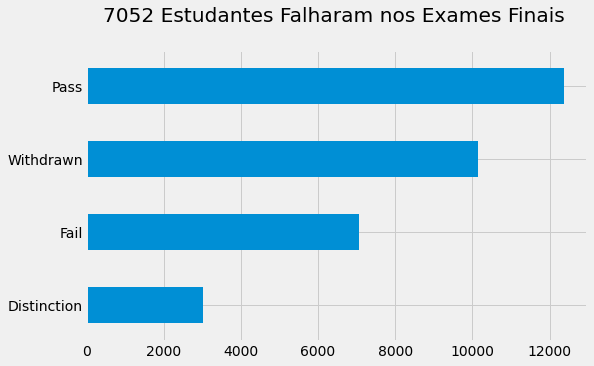

In [13]:
final_results = Counter(info['final_result'])
ax = (info
      .final_result
      .value_counts(ascending = True)
      .plot(kind = "barh"))
_= ax.set_ylabel("")
_= ax.set_title(str(final_results['Fail']) + ' Estudantes Falharam nos Exames Finais \n')

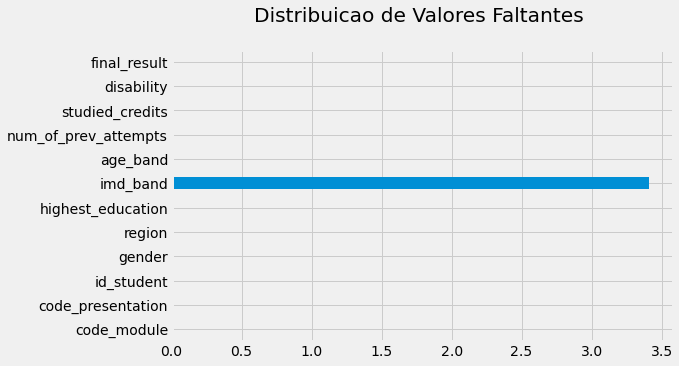

In [14]:
# Checando Valores Faltantes
ax = (info
 .isna()
 .mean()
 .mul(100)
 .plot(kind = "barh"))
_= ax.set_title("Distribuicao de Valores Faltantes \n")

In [15]:
# Numero de Niveis Distintos das Variaveis Categoricas
categorical_cardinality(info)

{'code_module': 7,
 'code_presentation': 4,
 'gender': 2,
 'region': 13,
 'highest_education': 5,
 'imd_band': 10,
 'age_band': 3,
 'disability': 2,
 'final_result': 4}

Nenhuma variável com cardinalidade proibitivamente alta, o que resultara em mais opções para escolher o *encoding* a ser usado na modelagem. *One-hot-encoding* nao sera caro computacionalmente :)

### 1.1.1 Modelagem/*Feature Engineering*

A variável *code_presentation* nao sera útil com o *encoding* atual, pois saber o ano em que o aluno realizou o modulo nao seria relevante no momento da inferência. Contudo os códigos **J/B** tem valor, pois a época do ano em que o modulo foi cursado pode conter poder preditivo.

In [16]:
info_clean = (info
 .assign(module_code = lambda df_:df_['code_presentation']
         .str
         .split('([A-Z])',expand = True)[1]))

assert list(info_clean['module_code'].unique()) == ['J', 'B'] # unit test

In [17]:
info_clean['module_code'].sample(5)

30787    J
21897    J
10451    B
2101     B
23067    B
Name: module_code, dtype: object

Para respondermos nossa questão de negocio (Quais estudantes falharão no Exame Final?), precisaremos reagrupar as categorias *Pass*/*Distinction* do alvo em Pass, alem de nao usarmos as observações em que os estudantes desistiram dos módulos (*Withdrawn*). Em experimentos futuros podemos verificar essa hipótese, mas nesse momento tememos produzirmos *data leakage* usando estas observações codificadas como *Fail*.

In [18]:
# Eliminando os estudantes que desistiram dos modulos
TARGET_MAP = {'Pass':'Pass','Fail':'Fail','Distinction':'Pass'}
info_clean = (info_clean
             .query("final_result != 'Withdrawn'")
             .assign(final_result = lambda df_:df_['final_result'].map(TARGET_MAP)))

assert list(info_clean['final_result'].unique()) == ['Pass', 'Fail']

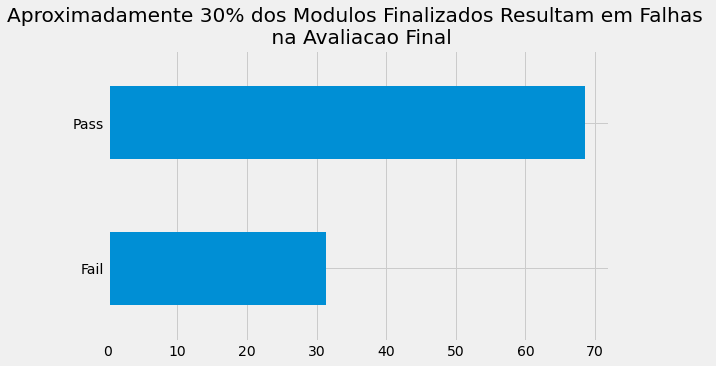

In [19]:
# Distribuicao do Alvo
ax = (info_clean['final_result']
 .value_counts(normalize = True,ascending = True)
 .mul(100)
 .plot(kind = 'barh'))
_= ax.set_title("Aproximadamente 30% dos Modulos Finalizados Resultam em Falhas \n na Avaliacao Final")

*Dataset* levemente desbalanceado, o que nos leva a usar algumas penalizações na função custo dos modelos (parâmetro *class weight*) de modo a dar oportunidade ao modelo de aprender melhor a classe *Fail*.Também precisamos estar atentos ao desbalaceamento no momento de dividir o *dataset* em partições de treino/teste de modo a preservar as proporções. O mesmo se aplica ao esquema de *Cross-Validation* que utilizaremos para avaliar o desempenho dos modelos. 

### 1.1.2 Modelo *Baseline*